In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun May 22 18:49:50 2022

@author: poojap

This is an algorithm detecting eating movements. This is calculated taking many
input actions and descerning eating movements from the rest.

It is an algorithm meant to take movement data from a wearable device in a designated time period of seconds,
and determine if the action is eating or non eating.

An accelerometer dataset is provided by watch measurements and gives us x, y, and z coordinates in space.

Time datasets are best analyzed by sectioning off a specific portion as a consequence of some number of seconds.

Windows are extracted with some overlap to ensure continuity even within consecutive windows. The windows
are further analyzed for feature engineering.

The large dataset is minimized via feature engineering. New features are calculated by the extracted windows.
The following features are extracted from each sliding window: 
    mean, median, mode, standard deviation, absolute average deviation, log average,
    square root average, squared average, minimum, maximum, range 
    
The data is considerably reduced after feature enigneering and the data is more appropriate and adept to 
train a classifier network.

A support vector machine (SVM) is used to classify the data as eating and non eating.
The following metrics are used to calculate model performance:
        Accuracy, Precision, Recall


"""

'\nCreated on Sun May 22 18:49:50 2022\n\n@author: poojap\n\nThis is an algorithm detecting eating movements. This is calculated taking many\ninput actions and descerning eating movements from the rest.\n\nIt is an algorithm meant to take movement data from a wearable device in a designated time period of seconds,\nand determine if the action is eating or non eating.\n\nAn accelerometer dataset is provided by watch measurements and gives us x, y, and z coordinates in space.\n\nTime datasets are best analyzed by sectioning off a specific portion as a consequence of some number of seconds.\n\nWindows are extracted with some overlap to ensure continuity even within consecutive windows. The windows\nare further analyzed for feature engineering.\n\nThe large dataset is minimized via feature engineering. New features are calculated by the extracted windows.\nThe following features are extracted from each sliding window: \n    mean, median, mode, standard deviation, absolute average deviation

In [2]:
# To import all necessary packages, please run: pip install -r ./requirements.txt 
!pip install -r ./requirements.txt

from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import svm, datasets
from sklearn.metrics import *
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
import os
import shutil
import glob
import statistics
import csv
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import TimeSeriesSplit



In [3]:
def classifyData():
    """
    Takes in numerous .txt files all in one directory, with the filepath: '../DataSetFiles/raw/watch/accel'
    Inserts a header in all the .txt files and saves to a new directory: '../DataSetFiles/HeaderFiles'
    Concatenates all the data in the new folder 'HeaderFiles' and converts to a pandas dataframe
    Returns:
        'df': dataframe pulled directly from all concatenated data
        'dataframe': df converted to Pandas Dataframe
        'dataset': df converted to Numpy Array
        'target': Binary class indicating eating (1) or noneating (0)
        'x': feature of dataset
        'y': feature of dataset
        'z':feature of dataset
        Binary class indicating eating or noneating: 'target'
        
    """
    
    #Pathway of current algorithm
    dir_path = os.getcwd()
    
    #Entering one directory above current algorithm to access dataset files
    path_parent = os.path.dirname(dir_path)
    
    print(dir_path, path_parent)
    #Pathway for dataset all '.txt' files
    data ='DataSetFiles/raw/watch/accel'

    # Concatening the file paths to access dataset directory
    readData = os.path.join(path_parent, data)

    #Concatening all the .txt files to read in python
    files = os.path.join(readData, "*.txt")

    # list of merged files returned
    joinedfiles = glob.glob(files)

    #Header describing each column in .txt file
    header = ['SubjectID', 'Class', 'TimeStamp', 'x', 'y', 'z']
    
    #New directory name to put files with appended header 'HeaderFiles'
    newdirname = "DataSetFiles/HeaderFiles"
    
    #Create path filename for new directory
    newdir = os.path.join(path_parent, newdirname)
    
    #Remove header directory if it already exists
    if os.path.exists(newdir):
        shutil.rmtree(newdir)
        
    #Make new directory to put files with appended header
    os.makedirs(newdir)

    #Copy all the files from dataset folder to newly created header folder
    for f in joinedfiles:
        shutil.copy(f, newdir)
    
    #Join all the files in new 'HeaderFiles'
    joinnew = os.path.join(newdir, "*.txt")
    
    #List of merged files in 'HeaderFiles'
    newfiles = glob.glob(joinnew)
    
    #Loop to read data already existing in file
    for filename in joinedfiles:
        with open(filename) as infile:
            text = infile.read()
            reader = csv.reader(infile, delimiter=',' )
            
    #Loop to input headers followed by initial data
    for filename in newfiles:
        with open(filename, 'w') as outfile:
            # join the headers into a string with commas and add a newline
            outfile.write(f"{','.join(header)}\n") 
            outfile.write(text)
    
    #Concatenating all the new files with headers from 'HeaderFiles' directory and making a dataframe
    df = pd.concat(map(pd.read_csv, newfiles), ignore_index=True)
    print(df)
    #Replace Unknown time values with 0
    df['TimeStamp'] = df['TimeStamp'].replace(np.nan, 0)
    
    
    #Removing all the semicolons from column 'z'
    df['z'] = df['z'].str.replace(';','')
    
    #Creating a new column 'binary_eating' to indicate eating or non-eating in a binary fahsion
    df.insert(loc=6,
          column='binary_eating',
          value=0)
    
    #Creating a list of all the Class values in column 'Class'
    classes = df['Class']
    
    #Copying the data from column 'Class' into column 'binary_eating'    
    df['binary_eating'] = df['Class']
    
    #Classes that indicate eating
    eatingClasses = ['H', 'I', 'J', 'K', 'L']
    
    #Classes that do not indicate eating
    noneatingclasses = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']
    
    #Replacing all the eating classes with a value of 1
    for value in eatingClasses:
        df.loc[df['Class'] == value, 'binary_eating'] = 1
        
    #Replacing all the non-eating classes with a value of 0
    for nonval in noneatingclasses:
        df.loc[df['Class'] == nonval, 'binary_eating'] = 0

    #Creating a list of all the values in the column 'binary_eating'
    target = df['binary_eating']
    
    
    descriptors = df.drop(columns = ['SubjectID', 'Class', 'TimeStamp', 'binary_eating'])
    classes = df['binary_eating']

    return df, descriptors, classes


#Call the function to print necessary output
df, descriptors, classes= classifyData()
df.shape

/Users/poojap/Documents/prelimEatingDetection/Pooja/SupportVectorMachines /Users/poojap/Documents/prelimEatingDetection/Pooja
         SubjectID Class         TimeStamp         x         y            z
0             1638     A  1138138097322000  7.302415 -5.419930    4.485872;
1             1638     A  1138138117418000  6.540799 -3.321892  0.71371585;
2             1638     A  1138138137546000  3.264412 -2.723137  0.22513184;
3             1638     A  1138138157791000  1.070574 -3.319497   1.3771362;
4             1638     A  1138138177887000 -1.621428 -3.827241   1.0035132;
...            ...   ...               ...       ...       ...          ...
8200744       1638     S  1135293554939000 -4.071533 -7.891590  -1.3747413;
8200745       1638     S  1135293575112000 -3.877537 -7.846084  -1.4370118;
8200746       1638     S  1135293595208000 -3.702700 -7.915540  -1.5687379;
8200747       1638     S  1135293615414000 -3.578159 -8.176597  -1.8130299;
8200748       1638     S  113529363551

(8200749, 7)

In [4]:

length = len(df)*.3
validationset = df[(int(len(df) - length)):]
validationdf = pd.DataFrame(validationset)

trainingset = int(len(df) - length)
trainingdataframe = df[:trainingset]
for i, k in enumerate(validationdf['binary_eating']):
    if k ==1:
#         print(i)
        None

In [5]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics 
from sklearn.model_selection import KFold 
from functools import reduce

def crossValidate(dataframe, k):

    kf = KFold(n_splits=k, random_state=None)
    
    classes = dataframe['binary_eating']

    #display confusion matrices
    disp = []
    final_df = []
    count = 0
    for train_index , test_index in kf.split(dataframe):
        #how many iterations
        count +=1
        #Split train test each iteratoin
        
        # includes the target class in xtrain and xtest
        X_train , X_test = dataframe.iloc[train_index,:], dataframe.iloc[test_index, :]
        
        #only includes the target class
        y_train , y_test = classes[train_index] , classes[test_index]

        # appends this set of xtrain...ytest as a list to a list
        #final df is a list of lists. k number of lists inside
        final_df.append([X_train, X_test, y_train, y_test])
    
    return final_df

allTrains_Tests = crossValidate(trainingdataframe, 5) #list size of K
#Each list item is a list with Xtrain, Xtest, ytrain, ytest
# finaldf = [xtrain, xtest,ytrain, ytest]
# print(final_df, final_df.shape)

#Checking setup of alltraintests for all folds being held in list
print("value of specific set ", len(allTrains_Tests[2][0]))
xtrain = []
xtest = []
ytrain = []
ytest = []
#iterating through each list in the big list to pull x_train and x_test, y_train and y test
for i in allTrains_Tests:
    xtrain.append(i[0])
    xtest.append(i[1])
    ytrain.append(i[2])
    ytest.append(i[3])
    


value of specific set  4592419


In [6]:
filepath = Path('/Users/poojap/Documents/prelimEatingDetection/Pooja/Dataframes/' + 'validationdf.csv')
validationdf.to_csv(filepath)

In [7]:
# split validation into x and y
def splitXYvalidation(validationdataframe):
    print("hi")
    Xvalidation = validationdataframe.iloc[:, 0:-1]
    yvalidation = pd.DataFrame(validationdataframe.iloc[:, -1])
    
#     Xvalidationlist = Xvalidation.values.tolist()
#     yvalidationlist = yvalidation.values.tolist()
    return Xvalidation, yvalidation

xvalid_df, yvalid_df = splitXYvalidation(validationdf)
for ind, i in enumerate(yvalid_df):
    if i == 1:
        None


hi


In [8]:
print((yvalid_df[0:90
                
                ]))

        binary_eating
5740524             0
5740525             0
5740526             0
5740527             0
5740528             0
...               ...
5740609             0
5740610             0
5740611             0
5740612             0
5740613             0

[90 rows x 1 columns]


In [9]:

def extract_windows(array, mHZ, seconds, overlap):
    """
    Function to extract windows across the entire dataset.
    The window size is described by mHZ multiplied by time second window
    The input parameters are the following:
        'array': array (dataframe or list) indicating the feature of interest
        'mHZ': Signal frequency of how many measurments taken a second
        'seconds': How many seconds are taken for the window
        'overlap': How much overlap between consecutive windows
    The function returns a list of windows sectioning the input feature vector:
        'windows': list of arrays of the extracted windows
    """
    #Initializing list holding all windows
    allfolds = []

    print("list length: {}".format(len(array)))
    count = 0
    
    # iterate through each list in xtrain,xtest, etc. list
    for i, fold in enumerate(array):
        #initializing list holding specific set's windows
        windows = []
        #Convert input list/dataframe into numpy array
        setval = fold.to_numpy()
        #Calculate how many datapoints should be in each window
        windowSize = mHZ * seconds
#         print("initial overlap", overlap)
        #How many points should overlap between consecutive windows
        coverlap = 1 - overlap
#         print("overlap", coverlap)
        overlapamt = int(windowSize* coverlap)
        for i, value in enumerate(setval):
#             window = setval[ (overlapamt *i) : (overlapamt*i) +windowSize ]
            startval = (overlapamt *i)
            endval =(overlapamt*i) +windowSize
            window = setval[startval : endval ]
#             print(startval, endval)
            if len(window) != 0:
                windows.append(window)
#         print("length of windows {}".format(len(windows)))            
        if len(windows) !=0:
            allfolds.append(windows)
    return allfolds

#Call the function to get necessary output

# 5 second windows

# Cutting the x feature into windows forming a list of arrays. 20 mHz taken per second for 10 second windows
# with 50% overlap

xtrain_windows = extract_windows(xtrain, 20, 5, 0.25)

# Cutting the y feature into windows forming a list of arrays. 20 mHz taken per second for 10 second windows
# with 50% overlap
xtest_windows = extract_windows(xtest, 20, 5, 0.25)

# Cutting the z feature into windows forming a list of arrays. 20 mHz taken per second for 10 second windows
# with 50% overlap
ytrain_windows = extract_windows(ytrain, 20, 5, 0.25)

# Cutting the target classification list into windows forming a list of arrays. 20 mHz taken per second for 10 second windows
# with 50% overlap
# Done so classes dimensions match that of input features
ytest_windows = extract_windows(ytest, 20, 5, 0.25)

print(xtrain_windows[1][1])

list length: 5
list length: 5
list length: 5
list length: 5
[[1638 'A' 1138139608579000 6.06419 -3.8008962 '-4.253555' 0]
 [1638 'A' 1138139628675000 7.110813 -4.140989 '-4.373306' 0]
 [1638 'A' 1138139649566000 6.5168486 -4.8427296 '-2.339934' 0]
 [1638 'A' 1138139669694000 5.5372853 -5.1660576 '-0.033530276' 0]
 [1638 'A' 1138139689854000 5.1756372 -5.6426663 '1.0418335' 0]
 [1638 'A' 1138139710014000 3.6811452 -6.6749196 '1.6693287' 0]
 [1638 'A' 1138139730174000 2.5363257 -6.72761 '0.6011499' 0]
 [1638 'A' 1138139750334000 1.8010547 -6.231841 '-0.53169435' 0]
 [1638 'A' 1138139770481000 1.4154567 -5.9133034 '-1.465752' 0]
 [1638 'A' 1138139790609000 1.7315992 -5.127737 '-2.1674929' 0]
 [1638 'A' 1138139810770000 2.2393434 -4.2918754 '-2.2608986' 0]
 [1638 'A' 1138139830898000 1.9758912 -4.481082 '-1.9711012' 0]
 [1638 'A' 1138139850891000 2.2249732 -6.4282327 '-1.9567311' 0]
 [1638 'A' 1138139870987000 3.290757 -9.175321 '-1.8345851' 0]
 [1638 'A' 1138139891215000 4.8427296 -11.951

In [10]:
# print(ytest_windows[1][1])
from itertools import chain

print(type(yvalid_df))
setval = yvalid_df.values.tolist()
setval = list(chain.from_iterable(setval))

setval

<class 'pandas.core.frame.DataFrame'>


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [11]:
def extractValidationwindowsX(validationdf, mHZ, seconds, overlap):
    #Initializing list holding all windows

    count = 0
    
    setval = validationdf.values.tolist()

    # iterate through each list in xtrain,xtest, etc. list
    #initializing list holding specific set's windows
    windows = []
    #Convert input list/dataframe into numpy array
    #Calculate how many datapoints should be in each window
    windowSize = mHZ * seconds

    #How many points should overlap between consecutive windows
    coverlap = 1 - overlap
    overlapamt = int(windowSize* coverlap)
    for i, value in enumerate(setval):
        window = setval[(overlapamt *i) : (overlapamt*i) +windowSize]
        if len(window) != 0:
            windows.append(window)
    print("length of windows {}".format(len(windows)))
    return windows






def extractValidationwindowsY(validationdf, mHZ, seconds, overlap):
    #Initializing list holding all windows

    count = 0
    
    setval = validationdf.values.tolist()
    setval = list(chain.from_iterable(setval))

    # iterate through each list in xtrain,xtest, etc. list
    #initializing list holding specific set's windows
    windows = []
    #Convert input list/dataframe into numpy array
    #Calculate how many datapoints should be in each window
    windowSize = mHZ * seconds

    #How many points should overlap between consecutive windows
    coverlap = 1 - overlap
    overlapamt = int(windowSize* coverlap)
    for i, value in enumerate(setval):
        window = setval[(overlapamt *i) : (overlapamt*i) +windowSize]
        if len(window) != 0:
            windows.append(window)
    print("length of windows {}".format(len(windows)))
    return windows
xvalidationWindows = extractValidationwindowsX(xvalid_df, 20, 5, .25)

yvalidationWindows = extractValidationwindowsY(yvalid_df, 20, 5, .25)
for ind, i in enumerate(yvalidationWindows):
    for val in i:
        if val == 1:
#             print(ind)
            None
print((xvalidationWindows[1476]))

length of windows 32803
length of windows 32803
[[1638, 'G', 1136812170069000, 0.16046631, -7.7574687, '5.333709'], [1638, 'G', 1136812190165000, 0.15088624, -7.783814, '5.3384986'], [1638, 'G', 1136812210493000, 0.12454102, -7.8412943, '5.367239'], [1638, 'G', 1136812230589000, 0.10538086, -7.8412943, '5.3792143'], [1638, 'G', 1136812250773000, 0.100590825, -7.8365045, '5.360054'], [1638, 'G', 1136812270869000, 0.13891114, -7.831714, '5.3552637'], [1638, 'G', 1136812290969000, 0.17004639, -7.838899, '5.360054'], [1638, 'G', 1136812311065000, 0.16525635, -7.8484793, '5.372029'], [1638, 'G', 1136812331269000, 0.17483643, -7.8580594, '5.362449'], [1638, 'G', 1136812351365000, 0.17483643, -7.8484793, '5.345684'], [1638, 'G', 1136812371568000, 0.18441652, -7.8604546, '5.326524'], [1638, 'G', 1136812391664000, 0.17962648, -7.903565, '5.360054'], [1638, 'G', 1136812411969000, 0.16286133, -7.927515, '5.352869'], [1638, 'G', 1136812432065000, 0.15088624, -7.9083548, '5.3408937'], [1638, 'G', 1

In [12]:
print((yvalidationWindows[1476]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [13]:
# Pulling x window, y window, z window, and target class out of each set


def getCoordinates(traintestset):
    #get x coordinate
    x_windows = []
    count = 0
    xfold = []

    for fold in traintestset:
        xwindows = []
        for x_windows in fold:
            xdata = []
            for k in x_windows:
                xdata.append(k[3])
            xwindows.append(xdata)
        xfold.append(xwindows)
    print("x DATA", len(xfold), len(xfold[1]), len(xfold[1][1]))
    
    #get y coordinate
    yfold = []
    for fold in traintestset:
        ywindows = []
        for y_windows in fold:
            ydata = []
            for k in y_windows:
                ydata.append(k[4])
            ywindows.append(ydata)
        yfold.append(ywindows)
    print("y data", len(yfold), len(yfold[1]), len(yfold[1][1]))

    #get z coordinate
    zfold = []
    for fold in traintestset:
        zwindows = []
        for z_windows in fold:
            zdata = []
            for k in z_windows:
                zdata.append(float(k[5]))
            zwindows.append(zdata)
        zfold.append(zwindows)
    print("z data", len(zfold), len(zfold[1]), len(zfold[1][1]))

    return xfold, yfold, zfold

xtrainX, xtrainY, xtrainZ = getCoordinates(xtrain_windows)
xtestX, xtestY, xtestZ = getCoordinates(xtest_windows)
# ytrain_windows and ytest_windows both only have one label
#Ytrain and Ytest are target_windows
yTrain = ytrain_windows
yTest = ytest_windows



x DATA 5 61233 100
y data 5 61233 100
z data 5 61233 100
x DATA 5 15309 100
y data 5 15309 100
z data 5 15309 100


In [14]:
def getValidationCoordinates(validationset_features):
    xcoordinates = []
    ycoordinates = []
    zcoordinates = []

    count = 0

    for i, window in enumerate(validationset_features):
        xdata = []
        ydata = []
        zdata = []
        for k in window:
            xdata.append(float(k[3]))
            ydata.append(float(k[4]))
            zdata.append(float(k[5]))
        xcoordinates.append(xdata)
        ycoordinates.append(ydata)
        zcoordinates.append(zdata)
    return xcoordinates, ycoordinates, zcoordinates


    
#validation
xValidX, xValidY, xValidZ = getValidationCoordinates(xvalidationWindows)
yValid = (yvalidationWindows)
# print(xValidX[1], xValidY[1], xValidZ[1])
for ind, i in enumerate(yValid):
    if ind == 1476:
        print(i)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [15]:
print((xtrainX[0][0][:10]), (xtrainX[1][0][:10]) )
if xtrainX[0][0] == xtrainX[0][1]:
    print("equal")
else:
    print("not equal")

[-1.961521, -1.4034815, -1.341211, -1.5064673, -1.331631, -1.0298585, -0.64186525, -0.488584, -1.0585986, -2.2297633] [7.302415, 6.5407987, 3.2644117, 1.0705738, -1.6214283, -5.760022, -9.101074, -3.65959, 5.5684204, 8.58854]
not equal


In [16]:
def featureEngineeringX(x_windows):
    """
    This function engineers features to reduce dataset complexity and 
    make the data more readable for the model. This reduces the number of data points
    needing to be handled, significantly.
    The input parameters are the following:
        'x_windows': list of windows extracted from x feature
        'y_windows': list of windows extracted from y feature
        'z_windows': list of windows extracted from z feature
        'target_windows': list of windows extracted from target 
    The following features are engineereed and returned in terms of x, y, and z:
        'mean': average of the window
        'median': middle value of the entire window
        'mode': most common value in the window
        'std': standard deviation of the window
        'aad': absolute average deviation of the window
        'range': difference in values in each window
        'minimum': minimum value in the window
        'maximum': maximum value in the window
        'log': log of every value in the window averaged together
        'sqrt': square root of every value in the window averaged together
        'square': every value in the window squared and then averaged
        'sum': sum of all the values in the window
        
    """
    print(len(x_windows[0]))
    xmeanfold = []
    xstdfold = []
    xsqrtavg_fold = []
    xlogavgfold = []
    xminfold = []
    xmaxfold = []
    xrangefold = []
    xmodefold = []
    xabsavgdevfold = []
    xsumfold = []
    xsquaredfold = []
    count = 0
    
    for k , fold in enumerate(x_windows):
        x_std = []
        x_absavgdev = []
        x_min = []
        x_max = []
        x_median = []
        x_mode = []
        x_range = []
        x_sqrtavg = []
        x_logavg = []
        x_sum = []
        x_sqrdavg = []
        x_mean = []
        
        for j, xwindow in enumerate(fold):
            xavg = np.mean(xwindow)
            xstd = np.std(xwindow)
            xaad = np.mean(np.absolute(xwindow - np.mean(xwindow)))
            xmin = min(xwindow)
            xmax = min(xwindow)
            xmedian = statistics.median(xwindow)
            xstat = statistics.mode(xwindow)
            xrange = np.ptp(xwindow)
            xsum = np.sum(xwindow)
            #log
            x_log = []
            for i in (xwindow):
                if i != 0:
                    x_log.append(math.log(np.abs(i)))
                else:
                    x_log.append(0)
            x_loga = np.mean(x_log)
            # square root
            sqrtx = []
            for i in xwindow:
                sqrtx.append(math.sqrt(np.abs(i)))
            sqrtxavg = (np.mean(sqrtx))
            # squared (^2)
            x_sqrd = []
            for i in (xwindow):
                x_sqrd.append((i)**2)
            x_sqrda = np.mean(x_sqrd)
            
            x_sqrdavg.append(x_sqrda)
            x_sqrtavg.append(sqrtxavg)
            x_logavg.append(x_loga)
            x_range.append(xrange)
            x_mode.append(xstat)
            x_median.append(xmedian)
            x_max.append(xmax)
            x_min.append(xmin)
            x_absavgdev.append(xaad)
            x_mean.append(xavg)
            x_std.append(xstd)
            x_sum.append(xsum)
        xsqrtavg_fold.append(x_sqrtavg)

        xlogavgfold.append(x_logavg)
        xmeanfold.append(x_mean)
        xstdfold.append(x_std)
        xminfold.append(x_min)
        xmaxfold.append(x_max)
        xrangefold.append(x_range)
        xmodefold.append(x_mode)
        xabsavgdevfold.append(x_absavgdev)
        xsumfold.append(x_sum)
        xsquaredfold.append(x_sqrdavg)
    
    xlist = [xsqrtavg_fold,xlogavgfold, xmeanfold,xstdfold,  xminfold, xmaxfold, xrangefold, 
              xmodefold, xabsavgdevfold, xsumfold, xsquaredfold]
    if xlist[2][0] == xlist[2][3]:
        print("equal")
    else:
        print("not equal")
    xFeaturesDict = {}
    xlistnames = ["xsqrtavg_fold","xlogavgfold", "xmeanfold","xstdfold",  "xminfold", "xmaxfold", "xrangefold", 
                  "xmodefold", "xabsavgdevfold", "xsumfold", "xsquaredfold"]
    
    for index, name in enumerate(xlistnames):
        xFeaturesDict[name] = xlist[index]
    
    return xFeaturesDict, xlist
#Call the function to get necessary output
#Doing Xtrain
XfeaturesTrain, xtrainlist = featureEngineeringX(xtrainX)
XfeaturesTest, xtestlist = featureEngineeringX(xtestX)
print(type(XfeaturesTrain))



61233
not equal
15309
not equal
<class 'dict'>


In [17]:
print(xValidZ[1])

[2.5938063, 0.4143384, 0.7424561, 1.4873072, 1.3795313, 1.5567628, 0.62031007, -2.9961696, -0.5125342, -0.117355965, -2.0429518, -2.929109, -2.8907888, -3.544629, -4.311035, -5.9013286, -1.4585669, 2.7422974, 1.7651294, -0.41912845, 0.50774413, 3.3458424, 2.6321266, -3.051255, -7.4892263, -8.586145, -7.582632, -1.0681788, 3.9374123, 3.412903, 2.5004005, -2.1435425, -4.9433208, -6.1647806, -8.59333, -6.0617948, -3.4009278, -0.22513184, 3.0536501, 1.4154567, -1.3052857, -0.34009278, 0.6322852, 0.91250247, 0.8646021, 0.80233157, 0.12454102, -0.46702883, -0.3065625, -0.47181886, -1.1783496, -0.7161109, -0.24668702, 1.099314, 1.3747413, -0.74006104, -3.523074, 0.5340894, 1.7986598, 0.87178713, 0.79035646, 1.7531544, 3.1853762, 4.0978785, 4.3086405, 2.6273365, 0.7209009, -0.031135255, -0.09580079, -0.05508545, -0.35685793, -0.90771246, -0.5604346, 0.58677983, 1.3627661, 1.829795, 2.5291407, 3.271597, 2.9698243, 2.069297, 1.6190332, 1.6262183, 1.468147, 0.57719976, -0.021555176, 0.2778223, 0.

In [18]:
def featureEngineeringValidationset(validation_coordinate):

    count = 0
    x_std = []
    x_absavgdev = []
    x_min = []
    x_max = []
    x_median = []
    x_mode = []
    x_range = []
    x_sqrtavg = []
    x_logavg = []
    x_sum = []
    x_sqrdavg = []
    x_mean = []
    for k, window in enumerate(validation_coordinate):
        if k == 1:
            print(np.mean(window))
        xavg = np.mean(window)
        xstd = np.std(window)
        xaad = np.mean(np.absolute(window - np.mean(window)))
        xmin = min(window)
        xmax = min(window)
        xmedian = statistics.median(window)
        xstat = statistics.mode(window)
        xrange = np.ptp(window)
        xsum = np.sum(window)
        #log
        x_log = []
        for i in (window):
            if i != 0:
                x_log.append(math.log(np.abs(i)))
            else:
                x_log.append(0)
        x_loga = np.mean(x_log)
        # square root
        sqrtx = []
        for i in window:
            sqrtx.append(math.sqrt(np.abs(i)))
        sqrtxavg = (np.mean(sqrtx))
        # squared (^2)
        x_sqrd = []
        for i in (window):
            x_sqrd.append((i)**2)
        x_sqrda = np.mean(x_sqrd)

        x_sqrdavg.append(x_sqrda)
        x_sqrtavg.append(sqrtxavg)
        x_logavg.append(x_loga)
        x_range.append(xrange)
        x_mode.append(xstat)
        x_median.append(xmedian)
        x_max.append(xmax)
        x_min.append(xmin)
        x_absavgdev.append(xaad)
        x_mean.append(xavg)
        x_std.append(xstd)
        x_sum.append(xsum)
    
    
    xlist = [x_sqrtavg,x_logavg, x_mean, x_std,  x_min, x_max, x_range, 
              x_mode, x_absavgdev, x_sum, x_sqrdavg]

    xFeaturesDict = {}
    xlistnames = ["xsqrtavg_fold","xlogavgfold", "xmeanfold","xstdfold",  "xminfold", "xmaxfold", "xrangefold", 
                 "xmodefold", "xabsavgdevfold", "xsumfold", "xsquaredfold"]
    
    for index, name in enumerate(xlistnames):
        xFeaturesDict[name] = xlist[index]
    validationDF_features = pd.DataFrame.from_dict(xFeaturesDict)

    return validationDF_features
#Call the function to get necessary output
#Doing Xtrain
validationset_Xfeatures = featureEngineeringValidationset(xValidX)
validationset_Yfeatures = featureEngineeringValidationset(xValidY)
validationset_Zfeatures = featureEngineeringValidationset(xValidZ)

-3.9784150133
-8.389514285
-0.0150886136600001


In [19]:
validationset_Xfeatures.head()

,xsqrtavg_fold,xlogavgfold,xmeanfold,xstdfold,xminfold,xmaxfold,xrangefold,xmodefold,xabsavgdevfold,xsumfold,xsquaredfold
0,1.966224,1.285968,-4.109997,2.170773,-15.581998,-15.581998,15.296991,-3.269202,1.486096,-410.999740,21.604333
1,2.035280,1.358830,-3.978415,2.631484,-11.491304,-11.491304,18.820064,-8.205338,1.683592,-397.841501,22.752493
2,2.046015,1.398174,-4.317598,1.465963,-7.680828,-7.680828,6.188731,-1.990261,1.182850,-431.759772,20.790699
3,1.992039,1.252771,-4.286726,2.633129,-13.745018,-13.745018,15.337706,-4.334986,1.996225,-428.672590,25.309388
4,2.059347,1.326364,-4.229892,3.083296,-13.155843,-13.155843,18.764979,-4.598438,2.101247,-422.989208,27.398698


In [20]:
def featureEngineeringY(y_windows):
    """
    This function engineers features to reduce dataset complexity and 
    make the data more readable for the model. This reduces the number of data points
    needing to be handled, significantly.
    The input parameters are the following:
        'x_windows': list of windows extracted from x feature
        'y_windows': list of windows extracted from y feature
        'z_windows': list of windows extracted from z feature
        'target_windows': list of windows extracted from target 
    The following features are engineereed and returned in terms of x, y, and z:
        'mean': average of the window
        'median': middle value of the entire window
        'mode': most common value in the window
        'std': standard deviation of the window
        'aad': absolute average deviation of the window
        'range': difference in values in each window
        'minimum': minimum value in the window
        'maximum': maximum value in the window
        'log': log of every value in the window averaged together
        'sqrt': square root of every value in the window averaged together
        'square': every value in the window squared and then averaged
        'sum': sum of all the values in the window
        
    """
    ymeanfold = []
    ystdfold = []
    ysqrtavg_fold = []
    ylogavgfold = []
    yminfold = []
    ymaxfold = []
    yrangefold = []
    ymodefold = []
    yabsavgdevfold = []
    ysumfold = []
    ysquaredfold = []
    count = 0
    
    for fold in y_windows:
        count = count + 1
        print(count)
        y_mean = []
        y_std = []
        y_absavgdev = []
        y_min = []
        y_max = []
        y_median = []
        y_mode = []
        y_range = []
        y_sqrtavg = []
        y_logavg = []
        y_sum = []
        y_sqrdavg = []

        for ywindow in fold:
            #Convert all string values to float
#             vector = np.vectorize(float)
#             for j in range(0, len(x_windows)):
#                 # print("array", j, ": ", x_windows[j])
#                 x_windows[j] = vector(x_windows[j])
#                 y_windows[j] = vector(y_windows[j])
#                 z_windows[j] = vector(z_windows[j])

        #Engineer the mean
            #x feature
            yavg = np.mean(ywindow)
            ystd = np.std(ywindow)
            yaad = np.mean(np.absolute(ywindow - np.mean(ywindow)))
            ymin = min(ywindow)
            ymax = min(ywindow)
            ymedian = statistics.median(ywindow)
            ystat = statistics.mode(ywindow)
            yrange = np.ptp(ywindow)
            ysum = np.sum(ywindow)
            #log
            y_log = []
            for i in (ywindow):
                if i != 0:
                    y_log.append(math.log(np.abs(i)))
                else:
                    y_log.append(0)
            y_loga = np.mean(y_log)
            # square root
            sqrty = []
            for i in ywindow:
                sqrty.append(math.sqrt(np.abs(i)))
            sqrtyavg = (np.mean(sqrty))
            # squared (^2)
            y_sqrd = []
            for i in (ywindow):
                y_sqrd.append((i)**2)
            y_sqrda = np.mean(y_sqrd)
            
            y_sqrdavg.append(y_sqrda)
            y_sqrtavg.append(sqrtyavg)
            y_logavg.append(y_loga)
            y_range.append(yrange)
            y_mode.append(ystat)
            y_median.append(ymedian)
            y_max.append(ymax)
            y_min.append(ymin)
            y_absavgdev.append(yaad)
            y_mean.append(yavg)
            y_std.append(ystd)
            y_sum.append(ysum)

        ysqrtavg_fold.append(y_sqrtavg)
        ylogavgfold.append(y_logavg)
        ymeanfold.append(y_mean)
        ystdfold.append(y_std)
        yminfold.append(y_min)
        ymaxfold.append(y_max)
        yrangefold.append(y_range)
        ymodefold.append(y_mode)
        yabsavgdevfold.append(y_absavgdev)
        ysumfold.append(y_sum)
        ysquaredfold.append(y_sqrdavg)
    
    ylist = [ysqrtavg_fold, ylogavgfold, ymeanfold, ystdfold,  yminfold, ymaxfold, yrangefold, 
              ymodefold, yabsavgdevfold, ysumfold, ysquaredfold]
    yFeaturesDict = {}
    ylistnames = ["ysqrtavg_fold", "ylogavgfold", "ymeanfold", "ystdfold",  "yminfold", "ymaxfold", "yrangefold", 
                  "ymodefold", "yabsavgdevfold", "ysumfold", "ysquaredfold"]
    for index, name in enumerate(ylistnames):
        yFeaturesDict[name] = ylist[index]
        
    return yFeaturesDict, ylist
#Call the function to get necessary output
#Doing Xtrain
YfeaturesTrain, ytrainlist = featureEngineeringY(xtrainY)
YfeaturesTest, ytestlist = featureEngineeringY(xtestY)
print(type(YfeaturesTrain))



1
2
3
4
5
1
2
3
4
5
<class 'dict'>


In [21]:
print(type(YfeaturesTrain))

<class 'dict'>


In [22]:
def featureEngineeringZ(z_windows):
    """
    This function engineers features to reduce dataset complexity and 
    make the data more readable for the model. This reduces the number of data points
    needing to be handled, significantly.
    The input parameters are the following:
        'x_windows': list of windows extracted from x feature
        'y_windows': list of windows extracted from y feature
        'z_windows': list of windows extracted from z feature
        'target_windows': list of windows extracted from target 
    The following features are engineereed and returned in terms of x, y, and z:
        'mean': average of the window
        'median': middle value of the entire window
        'mode': most common value in the window
        'std': standard deviation of the window
        'aad': absolute average deviation of the window
        'range': difference in values in each window
        'minimum': minimum value in the window
        'maximum': maximum value in the window
        'log': log of every value in the window averaged together
        'sqrt': square root of every value in the window averaged together
        'square': every value in the window squared and then averaged
        'sum': sum of all the values in the window
        
    """
    zmeanfold = []
    zstdfold = []
    zsqrtavg_fold = []
    zlogavgfold = []
    zminfold = []
    zmaxfold = []
    zrangefold = []
    zmodefold = []
    zabsavgdevfold = []
    zsumfold = []
    zsquaredfold = []
    count = 0
    
    for fold in z_windows:
        count = count + 1
        print(count)
        z_mean = []
        z_std = []
        z_absavgdev = []
        z_min = []
        z_max = []
        z_median = []
        z_mode = []
        z_range = []
        z_sqrtavg = []
        z_logavg = []
        z_sum = []
        z_sqrdavg = []

        for zwindow in fold:
            #Convert all string values to float
#             vector = np.vectorize(float)
#             for j in range(0, len(x_windows)):
#                 # print("array", j, ": ", x_windows[j])
#                 x_windows[j] = vector(x_windows[j])
#                 y_windows[j] = vector(y_windows[j])
#                 z_windows[j] = vector(z_windows[j])

        #Engineer the mean
            #x feature
            zavg = np.mean(zwindow)
            zstd = np.std(zwindow)
            zaad = np.mean(np.absolute(zwindow - np.mean(zwindow)))
            zmin = min(zwindow)
            zmax = min(zwindow)
            zmedian = statistics.median(zwindow)
            zstat = statistics.mode(zwindow)
            zrange = np.ptp(zwindow)
            zsum = np.sum(zwindow)
            #log
            z_log = []
            for i in (zwindow):
                if i != 0:
                    z_log.append(math.log(np.abs(i)))
                else:
                    z_log.append(0)
            z_loga = np.mean(z_log)
            # square root
            sqrtz = []
            for i in zwindow:
                sqrtz.append(math.sqrt(np.abs(i)))
            sqrtzavg = (np.mean(sqrtz))
            # squared (^2)
            z_sqrd = []
            for i in (zwindow):
                z_sqrd.append((i)**2)
            z_sqrda = np.mean(z_sqrd)
            
            z_sqrdavg.append(z_sqrda)
            z_sqrtavg.append(sqrtzavg)
            z_logavg.append(z_loga)
            z_range.append(zrange)
            z_mode.append(zstat)
            z_median.append(zmedian)
            z_max.append(zmax)
            z_min.append(zmin)
            z_absavgdev.append(zaad)
            z_mean.append(zavg)
            z_std.append(zstd)
            z_sum.append(zsum)

        zsqrtavg_fold.append(z_sqrtavg)
        zlogavgfold.append(z_logavg)
        zmeanfold.append(z_mean)
        zstdfold.append(z_std)
        zminfold.append(z_min)
        zmaxfold.append(z_max)
        zrangefold.append(z_range)
        zmodefold.append(z_mode)
        zabsavgdevfold.append(z_absavgdev)
        zsumfold.append(z_sum)
        zsquaredfold.append(z_sqrdavg)
    
    zlist = [zsqrtavg_fold, zlogavgfold, zmeanfold, zstdfold,  zminfold, zmaxfold, zrangefold, 
              zmodefold, zabsavgdevfold, zsumfold, zsquaredfold]
    zFeaturesDict = {}
    zlistnames = ["zsqrtavg_fold","zlogavgfold", "zmeanfold","zstdfold",  "zminfold", "zmaxfold", "zrangefold", 
                  "zmodefold", "zabsavgdevfold", "zsumfold", "zsquaredfold"]
    for index, name in enumerate(zlistnames):
        zFeaturesDict[name] = zlist[index]
    return zFeaturesDict, zlist
#Call the function to get necessary output
#Doing Xtrain
ZfeaturesTrain, ztrainlist = featureEngineeringZ(xtrainZ)
ZfeaturesTest, ztestlist = featureEngineeringZ(xtestZ)
print(type(ZfeaturesTrain))

1
2
3
4
5
1
2
3
4
5
<class 'dict'>


In [23]:
def classTargets(target_windows):
    #Target mode to reduce complexity and match feature sizes 
    targetfold = []
#     print(len(target_windows), len(target_windows[1]), len(target_windows[1][1]))
    for fold in target_windows:
        twindows = []
        for targetwindow in fold:
            target_mode = []
            targetv = statistics.mode(targetwindow)
            twindows.append(targetv)
        twindows = pd.DataFrame(twindows, columns = ['Class'])
        targetfold.append(twindows)
#     print(len(targetfold),len(targetfold[1]), (targetfold[1][1]))
#     targetdict = {}
#     targetdict["Mode of Class"] = targetfold
    return targetfold

targetsTrain = classTargets(yTrain)
targetsTest = classTargets(yTest)
print(type(targetsTrain))

<class 'list'>


In [24]:
def classTargets_Validation(targets_Validationset):
    modeofTarget = []
    for window in targets_Validationset:
        target_mode = []
        targetv = statistics.mode(window)
#         if targetv == 1:
#             print(targetv)
       
        modeofTarget.append(targetv)
    return modeofTarget

validationLabels_mode = classTargets_Validation(yValid)
# validationLabels_mode = pd.DataFrame(validationLabels_mode, columns = ['Class'])
# for ind, i in enumerate(validationLabels_mode):
#     if i == 1:
#         print(ind)
validationLabels = pd.DataFrame(validationLabels_mode, columns = ['Class'])
validationLabels[1477:1490]
# print(type(validationLabels_mode))

,Class
1477,1
1478,1
1479,1
1480,1
1481,1
1482,1
1483,1
1484,1
1485,1
1486,1


In [25]:
print(targetsTrain[4].equals(targetsTrain[3]))

False


In [26]:
def writeFeaturesToDataframe(Features): #  Yfeatures, Zfeatures, targets
    import xlsxwriter
    import openpyxl
    #Pathway of current algorithm
    dir_path = os.getcwd()
 
    #Entering one directory above current algorithm to access dataset files
    path_parent = os.path.dirname(dir_path)
    
    filename = 'FeaturesWorkbookS.csv'
    filetoappend = os.path.join(path_parent, filename)
    featurekeys = list(Features.keys())
    df = pd.DataFrame()
    df1 = pd.DataFrame()
    featurevalues = list(Features.values())
    n = len(featurevalues[0]) # number of folds and thus dataframes to create

    df_list = [pd.DataFrame() for x in range(n)]    
    [df1, df2, df3, df4, df5] = df_list 

    for num in df_list:
        for i, keys in enumerate(featurekeys):
            num.insert(i,keys, " ")
#     print(df_list)
    count = 0
#     df.to_csv(filetoappend, sep = ',')
#     with open(os.path.join(path_parent, filename), 'w') as csvfile:
    for index, feature in enumerate(Features.values()):
        for k, window in enumerate(feature):
            for i, num in enumerate(df_list):
                if k == i:
                    num[featurekeys[index]] = window
    count += 1
    print(count)
#             if k == 1:
#                 df2[xkeys[index]] = window
#             if k == 2:
#                 df3[xkeys[index]] = window
#             if k == 3:
#                 df4[xkeys[index]] = window
#             if k == 4:
#                 df5[xkeys[index]] = window
    return df_list
xfeattrain = writeFeaturesToDataframe(XfeaturesTrain)
yfeattrain = writeFeaturesToDataframe(YfeaturesTrain)
zfeattrain = writeFeaturesToDataframe(ZfeaturesTrain)

xfeattest = writeFeaturesToDataframe(XfeaturesTest)
yfeattest = writeFeaturesToDataframe(YfeaturesTest)
zfeattest = writeFeaturesToDataframe(ZfeaturesTest)

1
1
1
1
1
1


In [27]:
def writeValidationfeaturestoDf(xdf, ydf, zdf, target):
    xdf.columns = ["xsqrtavg_fold","xlogavgfold", "xmeanfold","xstdfold",  "xminfold", "xmaxfold", "xrangefold", 
                     "xmodefold", "xabsavgdevfold", "xsumfold", "xsquaredfold"]
#     ["xValidsqrtavg","xValidlogavg", "xValidmean","xValidstd",  "xValidmin", "xValidmax",
#                    "xValidrange", "xValidsqrtavg", "xValidmode", "xValidabsavg", "xValidsum",
#                    "xValidsquared"]
    ydf.columns =  ylistnames = ["ysqrtavg_fold", "ylogavgfold", "ymeanfold", "ystdfold",  "yminfold", "ymaxfold", "yrangefold", 
                                 "ymodefold", "yabsavgdevfold", "ysumfold", "ysquaredfold"]
#     ["yValidsqrtavg","yValidlogavg", "yValidmean","yValidstd",  "yValidmin", "yValidmax",
#                    "yValidrange", "yValidsqrtavg", "yValidmode", "yValidabsavgdev", "yValidsum",
#                    "yValidsquared"]
    zdf.columns = ["zsqrtavg_fold","zlogavgfold", "zmeanfold","zstdfold",  "zminfold", "zmaxfold", "zrangefold", 
                   "zmodefold", "zabsavgdevfold", "zsumfold", "zsquaredfold"]
#     ["zValidsqrtavg","zValidlogavg", "zValidmean","zValidstd",  "zValidmin", "zValidmax",
#                    "zValidrange", "zValidsqrtavg", "zValidmode", "zValidabsavgdev", "zValidsum",
#                    "zValidsquared"]
    
    joinx_y = pd.concat((xdf, ydf), axis = 1, join = 'inner')
    joinxy_z = pd.concat((joinx_y, zdf),  axis = 1, join = 'inner')
    joinxyz_targets = pd.concat((joinxy_z, target), axis = 1, join = 'inner')
    return joinxyz_targets


mergedValidationdf = writeValidationfeaturestoDf(validationset_Xfeatures, validationset_Yfeatures, 
                                                 validationset_Zfeatures, 
                                                 validationLabels)
mergedValidationdf.head()

,xsqrtavg_fold,xlogavgfold,xmeanfold,xstdfold,xminfold,xmaxfold,xrangefold,xmodefold,xabsavgdevfold,xsumfold,...,zmeanfold,zstdfold,zminfold,zmaxfold,zrangefold,zmodefold,zabsavgdevfold,zsumfold,zsquaredfold,Class
0,1.966224,1.285968,-4.109997,2.170773,-15.581998,-15.581998,15.296991,-3.269202,1.486096,-410.999740,...,-0.373024,2.733799,-14.767691,-14.767691,19.825972,0.526904,1.823017,-37.302430,7.612804,0
1,2.035280,1.358830,-3.978415,2.631484,-11.491304,-11.491304,18.820064,-8.205338,1.683592,-397.841501,...,-0.015089,2.701500,-8.593330,-8.593330,12.901971,2.593806,1.946595,-1.508861,7.298328,0
2,2.046015,1.398174,-4.317598,1.465963,-7.680828,-7.680828,6.188731,-1.990261,1.182850,-431.759772,...,0.264171,1.416270,-3.580554,-3.580554,6.852151,0.416733,1.159582,26.417067,2.075608,0
3,1.992039,1.252771,-4.286726,2.633129,-13.745018,-13.745018,15.337706,-4.334986,1.996225,-428.672590,...,-0.123511,2.486648,-10.665023,-10.665023,17.380658,1.362766,1.789055,-12.351117,6.198676,0
4,2.059347,1.326364,-4.229892,3.083296,-13.155843,-13.155843,18.764979,-4.598438,2.101247,-422.989208,...,-0.817971,2.675918,-9.656719,-9.656719,14.303057,-8.131092,1.973078,-81.797106,7.829614,0


In [28]:
def mergedataframes(xfeat, yfeat, zfeat, targets):
    [xdf1, xdf2, xdf3, xdf4, xdf5] = xfeat 
    [ydf1, ydf2, ydf3, ydf4, ydf5] = yfeat
    [zdf1, zdf2, zdf3, zdf4, zdf5] = zfeat
    [targ1, targ2, targ3, targ4, targ5] = targets
    
    n = len(xfeat)
    cvsets = [pd.DataFrame() for x in range(n)]    
    [cv1, cv2, cv3, cv4, cv5] = cvsets
    for i, df in enumerate(xfeat):
        cvsets[i] = pd.concat([xfeat[i], yfeat[i]], axis=1, join='inner')
        cvsets[i] = pd.concat([cvsets[i], zfeat[i]], axis=1, join='inner')
        cvsets[i] = pd.concat([cvsets[i], targets[i]], axis=1, join='inner')
    return cvsets
CVtrain = mergedataframes(xfeattrain, yfeattrain, zfeattrain, targetsTrain)
CVtest = mergedataframes(xfeattest, yfeattest, zfeattest, targetsTest)

In [29]:
[cv1train, cv2train, cv3train, cv4train, cv5train] = CVtrain
[cv1test, cv2test, cv3test, cv4test, cv5test] = CVtest
# cv2test.loc[cv2test.iloc['xsqrtavg_fold'] > 20]
import csv

from pathlib import Path  
filepath = Path('/Users/poojap/Documents/prelimEatingDetection/Pooja/Dataframes')
for ind,i in enumerate(CVtrain):
    filepath = Path('/Users/poojap/Documents/prelimEatingDetection/Pooja/Dataframes/' + 'CV' + str(ind) + '.csv')
    i.to_csv(filepath)

In [30]:
filepath = Path('/Users/poojap/Documents/prelimEatingDetection/Pooja/Dataframes/' + 'validationfeatures.csv')
mergedValidationdf.to_csv(filepath)

In [31]:
def cutCVtoTrainTestSets(TrainDataframe, TestDataframe):
    Xtrainsets = []
    Ytrainsets = []
    Xtestsets = []
    Ytestsets = []
    
    for i, fold in enumerate(TrainDataframe):
        Ytrain = fold["Class"] 
        Ytrainsets.append(Ytrain)
        Xtrain = fold.drop("Class", axis = 1)
        Xtrainsets.append(Xtrain)
    
    for i, fold in enumerate(TestDataframe):
        Ytest = fold["Class"]
        Ytestsets.append(Ytest)
        Xtest = fold.drop("Class", axis = 1)
        Xtestsets.append(Xtest)
    return Xtrainsets, Ytrainsets, Xtestsets, Ytestsets
Xtrain, Ytrain, Xtest, Ytest = cutCVtoTrainTestSets(CVtrain, CVtest)


In [32]:
def cutValidationtoXvsY(Validationset):
    Xvalidation = Validationset.drop(["Class"], axis=1)
    
    Yvalidation = pd.DataFrame(Validationset["Class"])
    return Xvalidation, Yvalidation

xvalidation , yvalidation = cutValidationtoXvsY(mergedValidationdf)
# for i in yvalidation.values:
#     if i == 1:
#         print(i)

In [33]:
print(len(Xtest[-1]))

15309


In [ ]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

# https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

def Models(Xtrain, Ytrain, Xtest, Ytest, Xvalidation, Yvalidation):
    """ 
    Classification model named Support Vector Machine that is able to distinguish between two-group classification
    problems. After training the model with labeled data for each class/group, the model is able to categorize
    new data with predictions.
    The input parameters are the following:
        'Xtrain': Training set used to train the model with features
        'Xtest': Testing set used to test how model performance as control group
        'Ytrain': Training set used to test the model's features
        'Ytest': Testing set used to test model performance as control group
    The model is trained on given input data of the features engineered, and model performance is tested with
    known data used for testing. Model performance is evaluated using accuracy, precision, F1, and recall.
    Returns:
        'accuracy': Percentage reflecting how much of model output is equivalent to real output
        'precision': Ratio of True positives by All positives. The ability of the classifier
                    to not label a sample positive, when it is negative (label non-eating as non-eating)
        'recall': Ratio of True positives by True Positives + False Negatives.
                    Ratio of ability of the classifier to find all positive samples (label eating as eating)
        'F1': Mean of precision and recall. A value of 1 is optimal, 0 is worst. Calculated by
                        F1 = 2 * (precision * recall) / (precision + recall)
    """
    from sklearn import metrics
    # SVM
    from sklearn.svm import SVC as SVC
    import sklearn
    class_weights = {0: 0.001, 1: 0.99}
#     SVCclassifier = sklearn.svm.LinearSVC(kernel = 'linear', loss = 'hinge', max_iter = 100000, class_weight = 'balanced', 
#                                           probability = True) 
    SVCclassifier = SVC(kernel = 'linear', class_weight = class_weights, probability = True) 
#     SVCclassifier.compile(loss = 'binary_crossentropy')
#     model_params = {'cache_size': 100}
    
    # Random Forest Classifier
    from sklearn.ensemble import RandomForestClassifier as RFC
    RFclassifier = RFC(criterion = 'entropy', class_weight = class_weights)
#     RFclassifier.compile(loss = 'binary_crossentropy')
#     model_params = {'n_estimators': 250}
    
    # Logistic Regression
    from sklearn.linear_model import LogisticRegression
    LogisticRegression_classifier = LogisticRegression(random_state=0, class_weight = class_weights, 
                                                      max_iter = 100000)
    
    
    classifiers = [LogisticRegression_classifier, RFclassifier, SVCclassifier]
    # What to predict on? - change for validation or test
    Xpred =  Xvalidation
    Ytrue = Yvalidation
    import xgboost as xgb
    for i, fold in enumerate(Xtrain):
        print("SVC")
        SVCclassifier.fit(Xtrain[i], Ytrain[i])
        print("RF")
        RFclassifier.fit(Xtrain[i], Ytrain[i])
        print("Logistic Regression")
        LogisticRegression_classifier.fit(Xtrain[i], Ytrain[i])
    

    Y_predLR = LogisticRegression_classifier.predict(Xpred)
    Y_predRFC = RFclassifier.predict(Xpred)
    Y_predSVC = SVCclassifier.predict(Xpred)

    return Y_predLR, Y_predRFC, Y_predSVC, classifiers

Y_predLR, Y_predRFC, Y_predSVC, classifiers = Models(Xtrain, Ytrain, Xtest, Ytest, xvalidation , yvalidation )



SVC
RF
Logistic Regression
SVC
RF
Logistic Regression
SVC
RF
Logistic Regression
SVC


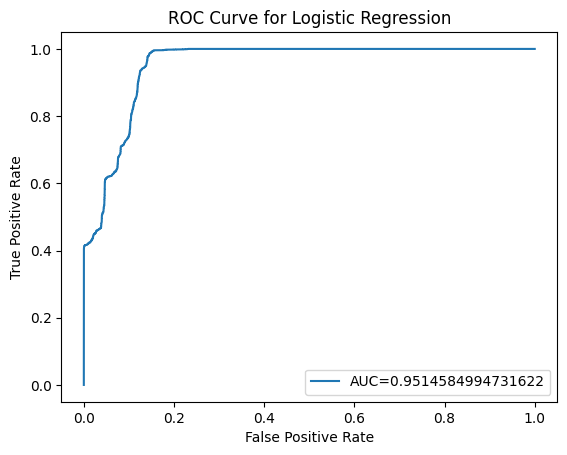

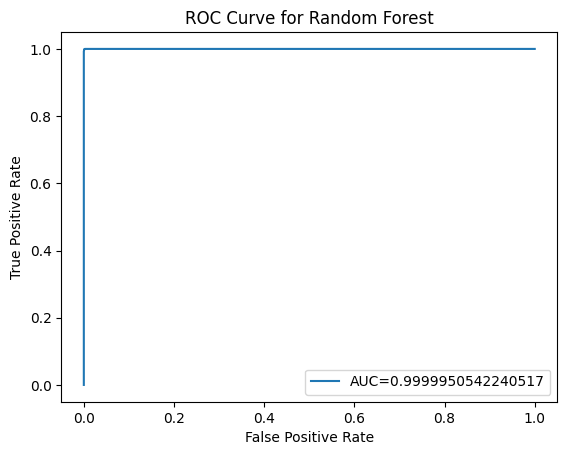

Logistic Regression: f1=0.814 auc=0.869


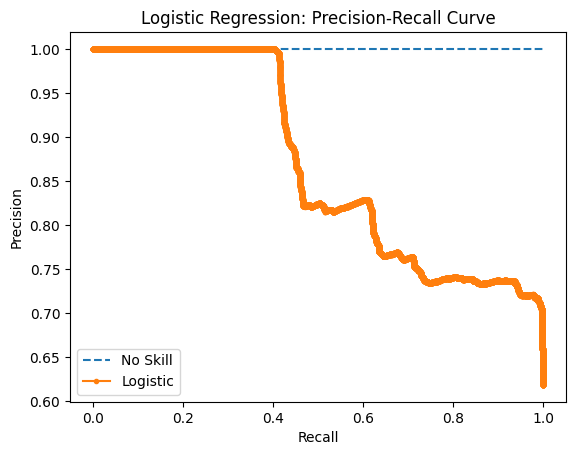

Random Forest: f1=0.998 auc=1.000


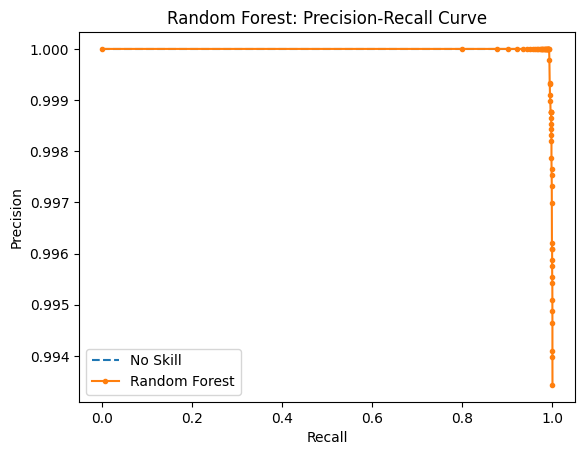

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [43]:
LogisticRegression = classifiers[0]
RFclassifier = classifiers[1]
SVMclassifier = classifiers[2]

Xpred =  xvalidation
Ytrue = yvalidation
####################################################
###### ROC AUC Curve ############################
####################################################
Y_predLR = LogisticRegression.predict(Xpred)
Y_predRFC = RFclassifier.predict(Xpred)
Y_predSVC = SVMclassifier.predict(Xpred)

#LOGISTIC REGRESSION
##################
y_pred_proba = LogisticRegression.predict_proba(Xpred)[::,1]
fpr, tpr, _ = metrics.roc_curve(Ytrue,  y_pred_proba)
auc = metrics.roc_auc_score(Ytrue, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve for Logistic Regression")
plt.legend(loc=4)
plt.show()

# RF
y_pred_proba = RFclassifier.predict_proba(Xpred)[::,1]
fpr, tpr, _ = metrics.roc_curve(Ytrue,  y_pred_proba)
auc = metrics.roc_auc_score(Ytrue, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve for Random Forest")
plt.legend(loc=4)
plt.show()

# svm
# y_pred_proba = SVMclassifier.predict_proba(Xpred)[::,1]
# fpr, tpr, _ = metrics.roc_curve(Ytrue,  y_pred_proba)
# auc = metrics.roc_auc_score(Ytrue, y_pred_proba)

# plt.plot(fpr,tpr,label="AUC="+str(auc))
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.title("ROC Curve for Support Vector Machine")
# plt.legend(loc=4)
# plt.show()

####################################################
###### Precision Recall curve ############################
####################################################


#LOGISTIC REGRESSION
##################
y_pred_proba = LogisticRegression.predict_proba(Xpred)[::,1]
precision, recall, thresholds = metrics.precision_recall_curve(Ytrue, y_pred_proba)
f1 = metrics.f1_score(Ytrue, Y_predLR)
lr_f1, lr_auc = metrics.f1_score(Ytrue, Y_predLR), metrics.auc(recall, precision)
# summarize scores
print('Logistic Regression: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(Ytrue[Ytrue==1]) / len(Ytrue)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Logistic Regression: Precision-Recall Curve")
# show the legend
plt.legend()
# show the plot
plt.show()

#RANDOM FOREST
##################
y_pred_proba = RFclassifier.predict_proba(Xpred)[::,1]
precision, recall, thresholds = metrics.precision_recall_curve(Ytrue, y_pred_proba)
f1 = metrics.f1_score(Ytrue, Y_predRFC)
lr_f1, lr_auc = metrics.f1_score(Ytrue, Y_predRFC), metrics.auc(recall, precision)
# summarize scores
print('Random Forest: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(Ytrue[Ytrue==1]) / len(Ytrue)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Random Forest: Precision-Recall Curve")
# show the legend
plt.legend()
# show the plot 
plt.show()

#SVM
##################
y_pred_proba = SVMclassifier.predict_proba(Xpred)[::,1]
precision, recall, thresholds = metrics.precision_recall_curve(Ytrue, y_pred_proba)
f1 = metrics.f1_score(Ytrue, Y_predSVC)
lr_f1, lr_auc = metrics.f1_score(Ytrue, Y_predSVC), metrics.auc(recall, precision)
# summarize scores
print('Support Vector Machine: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(Ytrue[Ytrue==1]) / len(Ytrue)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Support Vector Machine')
plt.title("Support Vector Machine: Precision-Recall Curve")

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error

def getMetrics(Y_predLR, Y_predRFC, Y_predSVC, Xvalidation, Yvalidation, Ytest):
    acc_score = []
    balancedaccuracy = []
    precision = []
    meanabserror = []
    MCC = []
    explainedvar = []
    rocauc = []
    confmatrices =[]
    recall = []
    disp = []
    
    ytrue = Yvalidation
    
    print(len(np.unique(Y_predRFC)))
#     accuracy
    accLR = metrics.accuracy_score(Y_predLR , ytrue)
    accRF = metrics.accuracy_score(Y_predRFC , ytrue)
    accSVC = metrics.accuracy_score(Y_predSVC , ytrue)
    acc_score.append(accLR)
    acc_score.append(accRF)
    acc_score.append(accSVC)

    # balanced accuracy 
    balanceaccLR = metrics.balanced_accuracy_score(Y_predLR, ytrue)
    balanceaccRF = metrics.balanced_accuracy_score(Y_predRFC, ytrue)
    balanceaccSVC = metrics.balanced_accuracy_score(Y_predSVC, ytrue)
    balancedaccuracy.append(balanceaccLR)
    balancedaccuracy.append(balanceaccRF)
    balancedaccuracy.append(balanceaccSVC)

    # precision
    precLR = metrics.precision_score(Y_predLR, ytrue)
    precRF = metrics.precision_score(Y_predRFC, ytrue)
    precSVC = metrics.precision_score(Y_predSVC, ytrue)
    precision.append(precLR)
    precision.append(precRF)
    precision.append(precSVC)

    # mean squared error 
    maeLR = metrics.mean_absolute_error(Y_predLR, ytrue)
    maeRF = metrics.mean_absolute_error(Y_predRFC, ytrue)
    maeSVC = metrics.mean_absolute_error(Y_predSVC, ytrue)
    meanabserror.append(maeLR)
    meanabserror.append(maeRF)
    meanabserror.append(maeSVC)

    # MCC
    mccLR = metrics.matthews_corrcoef(Y_predLR, ytrue)
    mccRF = metrics.matthews_corrcoef(Y_predRFC, ytrue)
    mccSVC = metrics.matthews_corrcoef(Y_predSVC, ytrue)
    MCC.append(mccLR)
    MCC.append(mccRF)
    MCC.append(mccSVC)

    # explained variance score
    expvarLR = metrics.explained_variance_score(Y_predLR, ytrue)
    expvarRF = metrics.explained_variance_score(Y_predRFC, ytrue)
    expvarSVC = metrics.explained_variance_score(Y_predSVC, ytrue)
    explainedvar.append(expvarLR)
    explainedvar.append(expvarRF)
    explainedvar.append(expvarSVC)

    # ROCAUC
    rocaucLR = metrics.roc_auc_score(Y_predLR,ytrue)
    rocaucRF = metrics.roc_auc_score(Y_predRFC, ytrue)
    rocaucSVC = metrics.roc_auc_score(Y_predSVC, ytrue)
    rocauc.append(rocaucLR)
    rocauc.append(rocaucRF)
    rocauc.append(rocaucSVC)

    #recall
    recallLR = metrics.recall_score(Y_predLR, ytrue, average = 'binary')
    recallRF = metrics.recall_score(Y_predRFC, ytrue, average = 'binary')
    recallSVC = metrics.recall_score(Y_predSVC, ytrue, average = 'binary')
    recall.append(recallLR)
    recall.append(recallRF)
    recall.append(recallSVC)

    #confusion matrix
    confusionmatrixLR = metrics.confusion_matrix(Y_predLR, ytrue)
    confusionmatrixRF = metrics.confusion_matrix(Y_predRFC, ytrue)
    confusionmatrixSVC = metrics.confusion_matrix(Y_predSVC, ytrue)
    
    specificities = []
    positive_predicted_value = []
    negative_predicted_value = []
    tn, fp, fn, tp  = metrics.confusion_matrix(Y_predLR, ytrue).ravel()
    specificityLR = (tn / (tn + fp))
    ppvLR = (tp)/(tp + fp)
    npv_LR = (tn) / (fn + tn)
    
    tn, fp, fn, tp  = metrics.confusion_matrix(Y_predRFC, ytrue).ravel()
    specificityRF = (tn / (tn + fp))
    ppvRF = (tp)/(tp + fp)
    npv_RF = (tn) / (fn + tn)

    tn, fp, fn, tp  = metrics.confusion_matrix(Y_predSVC, ytrue).ravel()
    specificitySVM = (tn / (tn + fp))
    ppvSVM = (tp)/(tp + fp)
    npv_SVM = (tn) / (fn + tn)

    negative_predicted_value.append(npv_LR)
    negative_predicted_value.append(npv_RF)
    negative_predicted_value.append(npv_SVM)

    specificities.append(specificityLR)
    specificities.append(specificityRF)
    specificities.append(specificitySVM)
    positive_predicted_value.append(ppvLR)
    positive_predicted_value.append(ppvRF)
    positive_predicted_value.append(ppvSVM)


#     classifier = RFclassifier.classes_
#         dispcm.plot() #dispcm
#         plt.show()
        
#     print("accuracy {}".format(acc_score))
#     print("balanced accuracy {}".format(balancedaccuracy))
#     print("precision {}".format(precision))
#     print("MCC {}".format(MCC))
#     print("explainedvar {}".format(explainedvar))
#     print("rocauc {}".format(rocauc))
#     print("recall {}".format(recall))
    
    allmetrics = {"accuracy": acc_score, "balancedacc": balancedaccuracy, "mae": meanabserror, "precision": precision,
                 "MCC": MCC, "explainedvar": explainedvar, "rocauc": rocauc, "recall": recall, "confusionmatrix":
                 confmatrices, "specificity": specificities, "positive_predicted_value": positive_predicted_value,
                 "negative_predicted_value": negative_predicted_value}
    print(allmetrics)
    return allmetrics

allmetrics = getMetrics(Y_predLR, Y_predRFC, Y_predSVC, xvalidation, yvalidation, Ytest)

2
{'accuracy': [0.8763527726122611, 0.9987805993354266, 0.6684449593025028], 'balancedacc': [0.8434003206035385, 0.9982173871538225, 0.6805238188729412], 'mae': [0.12364722738773892, 0.001219400664573362, 0.3315550406974972], 'precision': [0.996078431372549, 0.9985434173669467, 0.856358543417367], 'MCC': [0.7539573363873319, 0.9969236019491596, 0.40511728679335407], 'explainedvar': [0.5438119621807811, 0.9938499804069276, -0.07217345450380086], 'rocauc': [0.8434003206035384, 0.9982173871538225, 0.6805238188729412], 'recall': [0.6885601425141352, 0.9969795279113994, 0.4434066252828218], 'confusionmatrix': [], 'specificity': [0.9982404986929418, 0.9994552463962454, 0.9176410124630605], 'positive_predicted_value': [0.996078431372549, 0.9985434173669467, 0.856358543417367], 'negative_predicted_value': [0.831602311751403, 0.9988692520311584, 0.598207555071614]}


In [ ]:

def plotCM(allmetrics):
    metricsvalues = list(allmetrics.values())
    for i, section in enumerate(metricsvalues):
        metricsvalues[i] = section[-3:]
    SVMmetrics = []
    RFmetrics = []
    LRmetrics = []
    for j, metric in enumerate(metricsvalues):
        for i, modelmetric in enumerate(metric):
            if i == 2:
                SVMmetrics.append(modelmetric)
            if i == 1:
                RFmetrics.append(modelmetric)
            if i == 0:
                LRmetrics.append(modelmetric)
    print(SVMmetrics, RFmetrics, LRmetrics)
    colors = [plt.cm.Blues, plt.cm.Purples, plt.cm.Oranges]
    SVMCM = SVMmetrics[-1]
    RFCM = RFmetrics[-1]
    LRCM = LRmetrics[-1]
    CMs = [LRCM, RFCM, SVMCM]
    for i,cm in enumerate(CMs):
        dispcm = ConfusionMatrixDisplay(confusion_matrix = cm)
        dispcm.plot( cmap = colors[i])

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        if i == 2:
            plt.title('Support Vector Machine', fontsize=18)
        if i == 1:
             plt.title('Random Forest', fontsize=18)
        if i == 0:
             plt.title('Logistic\nRegression', fontsize=18)
        plt.show()
    return

plotCM(allmetrics)

In [ ]:
def plotLoss(allmetrics):
    loss = allmetrics["mae"]
    print(loss)
    SVMloss = []
    RFloss = []
    LRloss = []
    foldcount = 5
    for i in range(foldcount):
        if i == 0:
            LRloss.append(loss[i])
            print("i", i)
            RFloss.append(loss[i+1])
            print("i+1", i+1)
            SVMloss.append(loss[i+2])
            print("i+2", i+2)
        else:
            num = 3
            LRloss.append(loss[i*num])
            print("i", i*num)
            RFloss.append(loss[(i*num)+1])
            print("i+1", (i*num)+1)
            SVMloss.append(loss[(i*num)+2])
            print("i+2",(i*num)+2)
    xaxis = list(range(len(SVMloss)))
    for i, k in enumerate(xaxis):
        xaxis[i] = k+1
    print(xaxis)
    plt.plot(xaxis, LRloss, label = "Logistic \nRegression")
    plt.plot(xaxis, RFloss, label = "Random Forest")
    plt.plot(xaxis, SVMloss, label = "Support Vector\nMachine")
    plt.legend(loc='lower right')
    plt.xlabel("Iterations")
    plt.ylabel("Mean Absolute Error")
    plt.title("Loss over iterations for all Models")
        
plotLoss(allmetrics)

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 


def createPlots(allmetrics):
#     allmetrics = allmetrics.pop("confusionmatrix")
    print(allmetrics)
    metricsvalues = list(allmetrics.values())
    for i, section in enumerate(metricsvalues):
        metricsvalues[i] = section[-3:]
    SVMmetrics = []
    RFmetrics = []
    LRmetrics = []
    
    for j, metric in enumerate(metricsvalues):
        for i, modelmetric in enumerate(metric):
            if i == 2:
                SVMmetrics.append(modelmetric)
            if i == 1:
                RFmetrics.append(modelmetric)
            if i == 0:
                LRmetrics.append(modelmetric)
    
    print("Logistic Regression", LRmetrics)
    
    modelnames = ["LR", "RFC", "SVM"]
    allmetrics_ALL = [LRmetrics, RFmetrics, SVMmetrics] 
#     std_ALL = [std_RFC , std_SVM , std_MLP]
#     allmetrics = {"accuracy": acc_score, "balancedacc": balancedaccuracy, "mae": meanabserror, "precision": precision,
#                  "MCC": MCC, "explainedvar": explainedvar, "rocauc": rocauc, "recall": recall, "confusionmatrix":
#                  confmatrices, "specificity": specificities, "positive_predicted_value": positive_predicted_value,
#                  "negative_predicted_value": negative_predicted_value}
    label_text = ['Accuracy', 'BalancedAccuracy', 'Mean\nAbsolute\nError', 'Precision', 'MCC', 'Explained\nVariance',
                  'ROC-AUC', 'Recall', "Specificity", "Positive\nPredicted\nvalue", "Negative\nPredicted\nvalue"]
    # MeanAbsoluteError (between balacc and prec) confusionmatrix at the end
    colornames = ['red','#1e1ebd','green']
    X_axis = np.arange(len(SVMmetrics))
    totalwidth = 0.8
    nmodels = len(modelnames)  
    widthval = totalwidth / nmodels
    leftedge = (widthval - totalwidth) / 2
    rightedge = 0 - leftedge
    centers = np.linspace(leftedge,rightedge,nmodels)
    print("Centers: ", centers)
    fig = plt.subplots(figsize =(15, 7))
    for indexval, itemval in enumerate(modelnames):
        plt.bar(X_axis + centers[indexval], allmetrics_ALL[indexval], widthval, label = itemval, color = colornames[indexval])
        
    plt.xticks(X_axis, label_text, fontsize = 14)
    plt.xlabel("Metrics", fontweight = 'bold', fontsize = 16)
    plt.ylabel("Metric Value", fontweight = 'bold', fontsize = 16)
    plt.title("Predictor Model Performance", fontweight = 'bold', fontsize = 20)
    plt.legend()
    plt.show()
    

    LRdict = {}
    RFdict = {}
    SVMdict = {}
    
    for i, val in enumerate(LRmetrics):
        LRdict[label_text[i]] = LRmetrics[i]
        RFdict[label_text[i]] = RFmetrics[i]
        SVMdict[label_text[i]] = SVMmetrics[i]
        
    print("SVMdict: {}\n RFdict: {}\n MLPdict: {}\n".format(SVMdict, RFdict, RFdict))
    
createPlots(allmetrics)

In [ ]:
def main():
    #Starting timer
    start_time = time.time()
    

    #Call the function to define dataframe, get descripotrs and classes as separate variables too
    df, descriptors, classes= classifyData()

    # Cross validation f
    allTrains_Tests = crossValidate(df, 5) #list size of k(2nd parameter), CV split size
    [CV1, CV2, CV3, CV4, CV5 ] = allTrains_Tests
    
    for i in allTrains_Tests:
        xtrain = i[0]
        xtest = i[1]
        ytrain = i[2]
        ytest = i[3]
        
        xtrain_windows = extract_windows(xtrain, 20, 5,  .5)

        # Cutting the y feature into windows forming a list of arrays. 20 mHz taken per second for 10 second windows
        # with 50% overlap
        xtest_windows = extract_windows(xtest, 20, 5,  .5)

        # Cutting the z feature into windows forming a list of arrays. 20 mHz taken per second for 10 second windows
        # with 50% overlap
        ytrain_windows = extract_windows(ytrain, 20, 5, .5)

        # Cutting the target classification list into windows forming a list of arrays. 20 mHz taken per second for 10 second windows
        # with 50% overlap
        # Done so classes dimensions match that of input features
        ytest_windows = extract_windows(ytest, 20, 5, .5)
        
        # Get spatial coordinates from following functions (x, y, z, CLASS Labels)
        xtrainX, xtrainY, xtrainZ = getCoordinates(xtrain_windows)
        xtestX, xtestY, xtestZ = getCoordinates(xtest_windows)
        # ytrain_windows and ytest_windows both only have one label
        #Ytrain and Ytest are target_windows
        yTrain = ytrain_windows
        yTest = ytest_windows
        
        
        # Feature Engineer each set and create dataframe
        Train = featureEngineering(xtrainX, xtrainY, xtrainZ, ytrain_windows)
        Test = featureEngineering(xtestX, xtestY, xtestZ, ytest_windows)
        print(type(Train))
        
        # Append new features from previous feature engineering
        appended_dfTrain = AppendNewFeatures(Train, df)
        appended_dfTest = AppendNewFeatures(Test, df)
        print(appended_dfTrain.shape)
        appended_dfTest.head()
        appended_dfTrain.head()
        appended_df
        
        # Call splitX_Ydata 
        Xtrain , Ytrain = splitX_Ydata(appended_dfTrain)
        Xtest, Ytest = splitX_Ydata(appended_dfTest)
        
        #SVM
        accuracy, precision, recall, F1 = SVM(Xtrain, Xtest, Ytrain, Ytest)


    print(len(ytrain_windows))

    print("--- %s seconds ---" % (time.time() - start_time))
   

    

In [ ]:
if __name__ == '__main__':
    main()

In [ ]:
F1